# Deep Learning Project: Pet Classifier using CNN

Prepration
- Extract the ipynb file and the data in the same folder

Data Set
- A production grade program as 10,000 training images
- This is a small program with 20 images of cats and 20 images of dogs. 
- The evaluation set has 10 images of cats and 10 images of dogs

Runs
- The student is expected to run the 100-300 training step
- A production grade code would have about 20k-50k training steps

### Import modules

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import sys

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Set hyper parameters
- Run the program with three num_steps : 100,200,300

In [3]:
reset_graph()

img_size = 32
num_channels = 3
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)
trainpath='./data/train'
testpath='./data/test'
labels = {'cats': 0, 'dogs': 1}
fc_size=32 #size of the output of final FC layer
num_steps=15000#Try 100, 200, 300. number of steps that training data should be looped. Usually 20K
tf.logging.set_verbosity(tf.logging.INFO)

### Read the image dataset

length of train image set 40
X_data shape: (40, 32, 32, 3)
y_data shape: (40,)


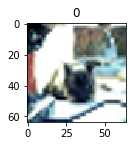

In [4]:
def read_images_classes(basepath,imgSize=img_size):
    image_stack = []
    label_stack = []

    for counter, l in enumerate(labels):
        path = os.path.join(basepath, l,'*g')
        for img in glob.glob(path):
            one_hot_vector =np.zeros(len(labels),dtype=np.int16)
            one_hot_vector[counter]=1
            image = cv2.imread(img)
            im_resize = cv2.resize(image,img_shape, interpolation=cv2.INTER_CUBIC)
            image_stack.append(im_resize)
            label_stack.append(labels[l])            
    return np.array(image_stack), np.array(label_stack)

X_train, y_train=read_images_classes(trainpath)
X_test, y_test=read_images_classes(testpath)

#test a sample image
print('length of train image set',len(X_train))
print('X_data shape:', X_train.shape)
print('y_data shape:', y_train.shape)

fig1 = plt.figure() 
ax1 = fig1.add_subplot(2,2,1) 
img = cv2.resize(X_train[0],(64,64), interpolation=cv2.INTER_CUBIC)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(y_train[0])
plt.show()

### Assignment: Define the tensorflow model

The model should have the following layers
- input later
- conv layer 1 with 32 filters of kernel  size[5,5],
- pooling layer 1 with pool size[2,2] and stride 2
- conv layer 2 with 64 filters of kernel  size[5,5],
- pooling layer 2 with pool size[2,2] and stride 2
- dense layer whose output size is fixed in the hyper parameter: fc_size=32
- drop out layer with droput probability 0.4
- predict the class by doing a softmax on the output of the dropout layers

Training
- For training fefine the loss function and minimize it
- For evaluation calculate the accuracy

Reading Material
- For ideas look at tensorflow layers tutorial

### The cnn_model_fn has to be defined here by the student

In [5]:
def cnn_model_fn(features, labels, mode):
    
    #Input Layer
    input_layer = tf.reshape(features["x"],[-1,32,32,3])
    
    #Convolutional Layer1
    conv1 = tf.layers.conv2d(inputs = input_layer,filters = 32,
                            kernel_size = [5,5],padding="SAME",
                            activation = tf.nn.relu)
    # Pooling layer1 pool size = 2x2 ,strides = 2
    pool1 = tf.layers.max_pooling2d(inputs = conv1,pool_size = [2,2],
                                   strides= 2)
    
    #Convolutional Layer 2
    conv2 = tf.layers.conv2d(inputs =pool1,filters = 64,kernel_size =[5,5],
                            padding="SAME",activation = tf.nn.relu)
    
    # Pooling layer2 with pool size = 2x2 stride = 2
    pool2 = tf.layers.max_pooling2d(inputs = conv2,pool_size =[2,2],strides = 2)
    
    # Dense Layer with with output size fixed to 32
    pool2_flat = tf.reshape(pool2,[-1,8*8*64])
    
    dense = tf.layers.dense(inputs = pool2_flat,units = 1024,
                           activation = tf.nn.relu)

    # Dropout Layer with probability as 0.4
    dropout = tf.layers.dropout(inputs = dense,rate = 0.4,
                                training = mode == tf.estimator.ModeKeys.TRAIN)
    
    # Logits Layer
    logits = tf.layers.dense(inputs = dropout,units = 10)
    
    predictions = {
        "classes" :tf.argmax(input = logits, axis =1),
        "probabilities" : tf.nn.softmax(logits,name = "softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions = predictions)
    
    # Training the Data using loss function
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels =labels, logits = logits)
    
    # Configire the training op
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001)
        train = optimizer.minimize(cross_entropy, global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode , loss = cross_entropy ,
                                          train_op = train)
    
    
    # Evaluation of the model
    eval_input_fn = {
        "accuracy":tf.metrics.accuracy(labels = labels ,predictions = predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(mode = mode,loss = cross_entropy)

    ...
    ...

### Run the tensorflow model

This section will use the model defined by the student and run the training and evaluation step

In [6]:
#X_train = np.array((X_train/255.0),dtype=np.float16)
#X_test = np.array((X_test/255.0), dtype=np.float16)
X_train = np.array((X_train/255.0),dtype=np.float32)
X_test = np.array((X_test/255.0), dtype=np.float32)

pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/pets_convnet_model")
#pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn)
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_train}, y=y_train, batch_size=10,
                                                      num_epochs=None, shuffle=True)
pets_classifier.train(input_fn=train_input_fn, steps=num_steps, hooks=[logging_hook])
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test}, y=y_test, num_epochs=1,shuffle=False)
eval_results = pets_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/pets_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2ff663b080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/pets_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.09609

INFO:tensorflow:global_step/sec: 7.75528
INFO:tensorflow:probabilities = [[0.8952304  0.10439652 0.00001283 0.00002638 0.00002408 0.00007463
  0.00005902 0.00009591 0.00004445 0.00003577]
 [0.01965533 0.98032    0.00000028 0.0000024  0.00000415 0.00000832
  0.00000134 0.00000074 0.00000643 0.00000101]
 [0.15439278 0.8452708  0.00002895 0.00008086 0.00002083 0.00005086
  0.00004393 0.00003916 0.00004403 0.00002769]
 [0.04471917 0.9550823  0.00000336 0.00001403 0.00002668 0.00004255
  0.00002417 0.00001491 0.00005721 0.00001572]
 [0.9946542  0.00512752 0.0000079  0.00001541 0.00003476 0.00003819
  0.00001657 0.00001563 0.0000561  0.0000337 ]
 [0.02364015 0.9763557  0.00000017 0.00000047 0.00000135 0.00000018
  0.00000035 0.00000089 0.00000056 0.00000012]
 [0.00199596 0.9980014  0.0000002  0.00000048 0.00000032 0.00000043
  0.00000025 0.00000022 0.00000046 0.00000016]
 [0.02646331 0.97348154 0.00000069 0.00001219 0.00000179 0.00000925
  0.00000163 0.00000727 0.00001805 0.00000417]
 [0.041

INFO:tensorflow:loss = 0.0039911014, step = 601 (12.511 sec)
INFO:tensorflow:probabilities = [[0.9991055  0.00088842 0.00000013 0.00000043 0.00000164 0.00000113
  0.00000021 0.00000163 0.00000046 0.00000042]
 [0.0031155  0.99688417 0.00000001 0.00000007 0.00000009 0.00000002
  0.00000001 0.00000009 0.00000005 0.        ]
 [0.00498693 0.99500835 0.00000011 0.0000002  0.00000097 0.00000063
  0.00000072 0.00000035 0.0000016  0.00000013]
 [0.00081734 0.99918264 0.         0.         0.00000002 0.00000001
  0.         0.00000001 0.         0.00000001]
 [0.9983814  0.00161819 0.00000001 0.00000005 0.00000009 0.00000006
  0.00000003 0.00000012 0.00000012 0.00000006]
 [0.9978885  0.00210969 0.00000002 0.00000018 0.00000018 0.00000068
  0.0000002  0.0000002  0.00000017 0.00000016]
 [0.99608934 0.00390633 0.00000013 0.00000045 0.00000064 0.00000091
  0.00000041 0.00000049 0.00000077 0.00000057]
 [0.00309    0.996908   0.00000009 0.00000012 0.0000003  0.00000087
  0.00000025 0.00000014 0.00000009

INFO:tensorflow:global_step/sec: 7.86743
INFO:tensorflow:probabilities = [[0.00024578 0.99975413 0.         0.00000007 0.00000004 0.00000006
  0.00000001 0.00000002 0.00000004 0.00000002]
 [0.00003119 0.99996877 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9996897  0.00030919 0.00000001 0.00000015 0.00000015 0.00000041
  0.00000004 0.00000008 0.00000021 0.00000024]
 [0.99955004 0.00044992 0.         0.         0.00000001 0.00000001
  0.         0.         0.         0.        ]
 [0.00009259 0.999905   0.00000005 0.00000022 0.00000033 0.00000069
  0.00000024 0.00000035 0.00000031 0.00000009]
 [0.0004205  0.9995795  0.00000002 0.00000001 0.00000002 0.00000002
  0.00000002 0.00000001 0.00000004 0.00000001]
 [0.9998996  0.00009995 0.         0.00000002 0.00000008 0.00000008
  0.00000001 0.00000006 0.00000004 0.00000002]
 [0.99994695 0.00005307 0.         0.         0.         0.00000001
  0.         0.         0.00000001 0.        ]
 [0.9998568  0.

INFO:tensorflow:loss = 0.0005263724, step = 1301 (11.781 sec)
INFO:tensorflow:probabilities = [[0.9997131  0.0002867  0.         0.00000005 0.00000005 0.00000006
  0.         0.00000001 0.00000001 0.00000001]
 [0.9994522  0.00054759 0.         0.00000005 0.00000012 0.00000011
  0.00000001 0.00000001 0.00000004 0.00000001]
 [0.00064276 0.99935573 0.00000001 0.0000001  0.00000108 0.00000015
  0.00000003 0.00000011 0.0000001  0.00000001]
 [0.00077503 0.9992249  0.00000002 0.00000001 0.00000004 0.00000003
  0.00000002 0.00000002 0.00000007 0.00000001]
 [0.001384   0.998615   0.00000009 0.00000015 0.00000007 0.00000011
  0.00000011 0.00000022 0.00000007 0.00000002]
 [0.00089131 0.9991079  0.00000005 0.00000001 0.00000005 0.00000018
  0.00000006 0.00000014 0.00000021 0.00000012]
 [0.999995   0.00000498 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00084813 0.999148   0.00000025 0.00000025 0.0000002  0.00000156
  0.00000024 0.00000036 0.00000055 0.0000

INFO:tensorflow:global_step/sec: 7.99449
INFO:tensorflow:probabilities = [[0.00138318 0.99861646 0.00000002 0.00000003 0.         0.00000027
  0.0000001  0.00000001 0.00000002 0.00000001]
 [0.00007223 0.99992776 0.         0.         0.         0.00000001
  0.         0.         0.         0.        ]
 [0.9999988  0.00000115 0.00000001 0.00000001 0.00000001 0.00000002
  0.         0.00000002 0.00000002 0.00000001]
 [0.00015598 0.99984396 0.         0.         0.00000003 0.00000002
  0.         0.00000001 0.         0.        ]
 [0.00000258 0.9999974  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9998938  0.00010621 0.         0.         0.00000001 0.00000006
  0.         0.         0.00000001 0.00000001]
 [0.00000286 0.99999714 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999933  0.00000659 0.         0.00000005 0.00000001 0.00000005
  0.         0.00000002 0.00000018 0.00000002]
 [0.00016267 0.9998373 

INFO:tensorflow:loss = 0.000114441056, step = 2001 (12.488 sec)
INFO:tensorflow:probabilities = [[0.9999546  0.00004212 0.00000006 0.00000037 0.00000073 0.00000087
  0.00000011 0.00000056 0.00000024 0.00000035]
 [0.9999025  0.00009755 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.0000027  0.99999726 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999285 0.00000719 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99993694 0.00006307 0.         0.         0.         0.00000001
  0.         0.         0.         0.        ]
 [0.99996066 0.00003937 0.         0.         0.00000002 0.00000001
  0.         0.00000001 0.         0.00000001]
 [0.9999206  0.00007941 0.         0.         0.         0.
  0.         0.00000002 0.         0.        ]
 [0.0000351  0.9999645  0.00000002 0.00000007 0.00000011 0.00000021
  0.00000001 0.00000002 0.00000001 0.00000003]
 [0.00001945 0.9

INFO:tensorflow:global_step/sec: 7.99234
INFO:tensorflow:probabilities = [[0.99999154 0.00000841 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99992    0.00007993 0.         0.00000001 0.00000004 0.00000005
  0.         0.00000002 0.         0.        ]
 [0.00003768 0.99996233 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999763  0.00002375 0.         0.00000002 0.00000001 0.00000005
  0.         0.         0.00000001 0.00000005]
 [0.9999931  0.00000688 0.         0.         0.00000001 0.
  0.         0.         0.         0.        ]
 [0.00002415 0.9999758  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999732  0.00002684 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00005063 0.9999472  0.00000007 0.00000022 0.00000031 0.00000068
  0.00000007 0.00000028 0.00000033 0.00000002]
 [0.00004852 0.9999515  0.         0.         0

INFO:tensorflow:loss = 7.3494935e-05, step = 2701 (12.323 sec)
INFO:tensorflow:probabilities = [[0.999997   0.00000295 0.         0.         0.         0.
  0.         0.         0.00000001 0.        ]
 [0.00006654 0.9999317  0.00000002 0.00000017 0.00000057 0.0000006
  0.00000011 0.00000005 0.00000022 0.00000007]
 [0.99998    0.00002001 0.         0.00000001 0.00000001 0.00000005
  0.         0.         0.00000001 0.00000003]
 [0.00004836 0.9999516  0.         0.         0.00000002 0.00000001
  0.         0.         0.00000002 0.        ]
 [0.00002986 0.9999701  0.         0.         0.00000001 0.00000001
  0.00000002 0.00000001 0.00000001 0.        ]
 [0.00000999 0.99999    0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99981827 0.00018177 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999176  0.00008238 0.         0.         0.00000001 0.00000001
  0.         0.00000001 0.00000002 0.        ]
 [0.999908

INFO:tensorflow:global_step/sec: 7.74941
INFO:tensorflow:probabilities = [[0.00002046 0.9999795  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00008495 0.999915   0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999969  0.00000311 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999913  0.00000876 0.         0.00000001 0.         0.
  0.         0.         0.         0.        ]
 [0.0000087  0.9999913  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000003 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99998355 0.00001641 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00001574 0.99998426 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999654 0.00000343 0.         0.         0.00000001 0.00000001
  0

INFO:tensorflow:loss = 1.6939362e-05, step = 3401 (12.458 sec)
INFO:tensorflow:probabilities = [[0.000018   0.999982   0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00001415 0.9999858  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99997807 0.00001997 0.00000008 0.0000002  0.00000019 0.0000005
  0.00000004 0.00000035 0.00000054 0.00000016]
 [0.99999964 0.00000039 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999553  0.00004474 0.         0.         0.00000002 0.00000005
  0.         0.00000002 0.00000002 0.        ]
 [0.9999951  0.00000485 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.0000132  0.99998677 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00004291 0.9999571  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.999828   0.00017178 0.        

INFO:tensorflow:global_step/sec: 7.82985
INFO:tensorflow:probabilities = [[0.99999774 0.00000228 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00001402 0.99998593 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9998646  0.00013532 0.         0.00000001 0.00000013 0.00000003
  0.         0.         0.00000001 0.00000001]
 [0.99999535 0.00000461 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999919  0.00000808 0.00000001 0.00000003 0.         0.00000001
  0.         0.         0.00000001 0.00000002]
 [0.00001985 0.9999802  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00004162 0.9999584  0.         0.         0.00000001 0.
  0.         0.         0.         0.        ]
 [0.9999994  0.00000059 0.         0.         0.         0.00000001
  0.         0.         0.00000001 0.        ]
 [0.00000454 0.99999547 0.         0.         0

INFO:tensorflow:loss = 1.1419891e-05, step = 4101 (12.596 sec)
INFO:tensorflow:probabilities = [[0.9999999  0.0000001  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.0000016  0.99999845 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99998486 0.00001511 0.         0.         0.         0.00000001
  0.         0.00000001 0.         0.        ]
 [0.9999722  0.00002777 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000005 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000544 0.9999945  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999475 0.00000522 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999964 0.00000031 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00002596 0.999974   0.         0.    

INFO:tensorflow:global_step/sec: 7.65873
INFO:tensorflow:probabilities = [[0.00000993 0.9999901  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000004 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000711 0.99999285 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.999998   0.00000206 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999917 0.00000084 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000047 0.9999995  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.00000006 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999285 0.00000715 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000091 0.99999905 0.         0.         0.         0.
  0.       

INFO:tensorflow:loss = 4.2915094e-06, step = 4801 (12.547 sec)
INFO:tensorflow:probabilities = [[0.00001864 0.9999814  0.         0.         0.         0.00000001
  0.         0.         0.         0.        ]
 [0.99997056 0.00002928 0.         0.00000002 0.00000002 0.00000003
  0.         0.00000005 0.00000007 0.00000001]
 [0.9999795  0.00001969 0.00000002 0.0000001  0.00000011 0.00000012
  0.00000004 0.00000011 0.0000001  0.0000002 ]
 [0.00000088 0.99999917 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000013 0.9999999  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999901  0.00000991 0.         0.00000001 0.00000001 0.00000001
  0.         0.00000001 0.00000001 0.        ]
 [0.00000355 0.9999964  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000164 0.99999833 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999845 0.00

INFO:tensorflow:global_step/sec: 8.02767
INFO:tensorflow:probabilities = [[0.9999994  0.0000006  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000077 0.9999993  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999833 0.00000168 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.00000014 0.         0.00000001 0.         0.00000001
  0.         0.         0.00000001 0.        ]
 [0.99999964 0.00000038 0.         0.         0.00000001 0.
  0.         0.         0.         0.        ]
 [0.9999993  0.00000077 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999958  0.00000422 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000006 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.         0.         0.
  0

INFO:tensorflow:loss = 3.2305627e-06, step = 5501 (12.628 sec)
INFO:tensorflow:probabilities = [[1.         0.00000003 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00001247 0.9999875  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000008 0.9999999  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999726 0.00000279 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999976 0.00000021 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999995  0.00000053 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000163 0.99999833 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000993 0.9999901  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999964 0.0000003  0.         0.         0. 

INFO:tensorflow:global_step/sec: 7.79347
INFO:tensorflow:probabilities = [[0.00000055 0.9999994  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999857 0.00000138 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999917 0.00000083 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999774 0.00000221 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999994  0.00000059 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999924  0.00000768 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.0000001  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000274 0.99999726 0.         0.         0.         0.
  0.       

INFO:tensorflow:loss = 2.0146308e-06, step = 6201 (12.540 sec)
INFO:tensorflow:probabilities = [[0.999956   0.00004396 0.         0.00000001 0.00000002 0.00000001
  0.         0.         0.00000003 0.        ]
 [0.00000017 0.9999999  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00001658 0.99998283 0.00000002 0.00000003 0.00000009 0.00000008
  0.00000007 0.00000009 0.00000012 0.00000001]
 [1.         0.00000003 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999905 0.00000092 0.         0.         0.         0.00000001
  0.         0.         0.         0.        ]
 [0.00000006 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000188 0.9999981  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999956  0.00000436 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999785 0.00000216 0

INFO:tensorflow:global_step/sec: 8.18064
INFO:tensorflow:probabilities = [[0.9999993  0.00000076 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000018 0.9999999  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000008 0.9999999  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999995  0.00000052 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000061 0.9999994  0.         0.         0.         0.00000002
  0.00000001 0.00000001 0.00000001 0.        ]
 [0.00000096 0.99999905 0.         0.         0.00000001 0.00000002
  0.00000001 0.         0.         0.00000001]
 [0.9999968  0.00000324 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000765 0.9999924  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000003 0.         0.         0.       

INFO:tensorflow:loss = 2.9086902e-06, step = 6901 (12.738 sec)
INFO:tensorflow:probabilities = [[0.00000884 0.9999912  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999964 0.00000042 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000002 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999988  0.00000118 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000001 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000041 0.99999964 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999976 0.00000028 0.         0.         0. 

INFO:tensorflow:global_step/sec: 7.99763
INFO:tensorflow:probabilities = [[0.99999964 0.00000035 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000007 0.9999999  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999962  0.00000384 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.00000018 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99997115 0.00002881 0.00000001 0.00000005 0.00000002 0.00000002
  0.00000001 0.00000002 0.00000005 0.        ]
 [0.00000022 0.99999976 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999988  0.00000124 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99998534 0.00001464 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000003 1.         0.         0.         0.         0.
  0

INFO:tensorflow:loss = 5.364415e-07, step = 7601 (12.271 sec)
INFO:tensorflow:probabilities = [[0.00000034 0.99999964 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999917 0.00000081 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.999995   0.0000049  0.00000001 0.00000002 0.00000005 0.00000011
  0.00000001 0.00000001 0.00000003 0.00000003]
 [0.99999917 0.00000083 0.         0.         0.         0.00000001
  0.         0.         0.         0.        ]
 [0.00000001 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000001 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.00000007 0.         0.         0.         0.00000001
  0.         0.         0.00000001 0.        ]
 [0.99999905 0.00000091 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999976 0.00000024 0.

INFO:tensorflow:global_step/sec: 8.01192
INFO:tensorflow:probabilities = [[0.00000192 0.9999981  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000028 0.99999976 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000028 0.99999976 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999917 0.00000052 0.00000003 0.00000002 0.00000005 0.00000015
  0.00000003 0.00000012 0.00000013 0.00000001]
 [0.00000035 0.99999964 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.0000002  0.99999976 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999994  0.00000065 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999974  0.00000267 0.         0.         0.         0.
  0

INFO:tensorflow:probabilities = [[0.9999999  0.00000011 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000024 0.99999976 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999993  0.00000073 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000134 0.9999987  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.00000009 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000188 0.9999981  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999976 0.00000021 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9

INFO:tensorflow:loss = 5.4836204e-07, step = 8701 (12.293 sec)
INFO:tensorflow:probabilities = [[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000003 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000003 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999976 0.00000024 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.00000014 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000003 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000062 0.9999994  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999976 0.00000023 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0. 

INFO:tensorflow:global_step/sec: 8.12647
INFO:tensorflow:probabilities = [[0.9999951  0.00000473 0.         0.00000001 0.00000001 0.00000007
  0.00000001 0.00000001 0.00000001 0.00000001]
 [0.9999989  0.0000011  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000122 0.9999988  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000008 0.9999999  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999714 0.00000289 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000024 0.99999976 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.00000014 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.00000011 0.         0.         0.         0.
  0

INFO:tensorflow:probabilities = [[0.00000005 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000012 0.9999999  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000003 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999964 0.00000036 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000017 0.9999999  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999964 0.00000038 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1. 

INFO:tensorflow:global_step/sec: 8.09641
INFO:tensorflow:probabilities = [[0.99999905 0.00000094 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000001 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000005 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000002 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000053 0.9999995  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999964 0.00000037 0.         0.         0.         0.
  0.       

INFO:tensorflow:loss = 8.3446494e-08, step = 10101 (12.971 sec)
INFO:tensorflow:probabilities = [[0.99999964 0.00000035 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000052 0.9999995  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000003 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000003 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000004 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000002 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000003 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000001 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.00000007 0.         0.         0.

INFO:tensorflow:global_step/sec: 7.75124
INFO:tensorflow:probabilities = [[0.00000024 0.99999976 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000002 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.00000009 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000031 0.99999964 0.         0.         0.         0.00000001
  0.         0.         0.00000001 0.        ]
 [0.00000002 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000041 0.99999964 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000003 1.         0.         0.         0.         0.
  0

INFO:tensorflow:probabilities = [[0.00000252 0.9999975  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999976 0.00000028 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000001 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.0000001  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000003 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000002 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999976 0.00000029 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1. 

INFO:tensorflow:loss = 2.8610216e-07, step = 11201 (12.585 sec)
INFO:tensorflow:probabilities = [[0.00000007 0.9999999  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000001 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000004 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000001 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.0000002  0.99999976 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999917 0.00000081 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000055 0.9999994  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000006 0.         0.         0.

INFO:tensorflow:global_step/sec: 7.84794
INFO:tensorflow:probabilities = [[0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000009 0.9999999  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000001 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000002 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000009 0.9999999  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.       

INFO:tensorflow:probabilities = [[0.999992   0.00000802 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.00000007 0.         0.         0.00000002 0.
  0.00000001 0.00000001 0.00000001 0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000001 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000002 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000046 0.9999995  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000002 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.0

INFO:tensorflow:loss = 3.5762785e-08, step = 12301 (12.484 sec)
INFO:tensorflow:probabilities = [[1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.00000009 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999964 0.00000038 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000005 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999976 0.00000023 0.         0.         0.

INFO:tensorflow:global_step/sec: 7.74709
INFO:tensorflow:probabilities = [[1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999976 0.00000019 0.         0.00000001 0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.         0.         0.00000001
  0.         0.         0.         0.        ]
 [0.00000056 0.9999994  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000002 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0

INFO:tensorflow:loss = 1.1920928e-08, step = 13001 (12.248 sec)
INFO:tensorflow:probabilities = [[1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999975  0.0000025  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.

INFO:tensorflow:global_step/sec: 8.18009
INFO:tensorflow:probabilities = [[0.99999976 0.00000023 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000004 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.00000009 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000002 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000003 0.         0.         0.         0.
  0.       

INFO:tensorflow:probabilities = [[0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000001 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0. 

INFO:tensorflow:loss = 4.768371e-08, step = 14101 (12.608 sec)
INFO:tensorflow:probabilities = [[0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000002 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999999  0.00000015 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0. 

INFO:tensorflow:loss = 0.0, step = 14501 (12.776 sec)
INFO:tensorflow:probabilities = [[0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000001 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.00000002 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0

INFO:tensorflow:probabilities = [[0.00000005 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1. 